# Wavelet Filtering

In [4]:
#Importing the libraries to watch the 'fits' image and get the data array
import astropy
from astropy.io import fits
#Importing a library that is useful to read the original file
import pandas as pd
import pylab as plb
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pywt
from scipy.stats import chisquare
from scipy import asarray as ar,exp
#Importing a visual library with 
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors 
import random
from matplotlib import cm
import matplotlib.patches as mpatches

import numpy as np
import math 
import seaborn as sns
import datetime
plt.style.use('fivethirtyeight')
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['font.serif'] = 'Ubuntu' 
plt.rcParams['font.monospace'] = 'Ubuntu Mono' 
plt.rcParams['font.size'] = 14 
plt.rcParams['axes.labelsize'] = 12 
plt.rcParams['axes.labelweight'] = 'bold' 
plt.rcParams['axes.titlesize'] = 12 
plt.rcParams['xtick.labelsize'] = 12 
plt.rcParams['ytick.labelsize'] = 12 
plt.rcParams['legend.fontsize'] = 12 
plt.rcParams['figure.titlesize'] = 12 
plt.rcParams['image.cmap'] = 'jet' 
plt.rcParams['image.interpolation'] = 'none' 
plt.rcParams['figure.figsize'] = (16, 8) 
plt.rcParams['lines.linewidth'] = 2 
plt.rcParams['lines.markersize'] = 8
plt.rcParams["axes.grid"] = False

colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd: goldenrod', 'xkcd:cadet blue',
'xkcd:scarlet']
cmap_big = cm.get_cmap('Spectral', 512)
cmap = mcolors.ListedColormap(cmap_big(np.linspace(0.7, 0.95, 256))) 
bbox_props = dict(boxstyle="round,pad=0.3", fc=colors[0], alpha=.5)

# Pre-processing steps

In [5]:
data=pd.read_csv('data.csv',sep=';')

In [6]:
data=data.rename(columns={'Data':'Day','Godzina':'hour','Minuty':'minute','Wolumen':'Load'})

In [7]:
SECONDS=np.arange(900,900*len(data)+900,900)

In [8]:
data['seconds']=SECONDS

In [9]:
LOAD=data.Load

In [10]:
from scipy import signal
load_no_line=signal.detrend(LOAD,type='linear')
#load_no_constant=signal.detrend(load_no_line,type='constant')

In [11]:
clean_load=np.array(load_no_line)-np.array(load_no_line).mean()

In [12]:
data['clean_load']=clean_load

In [13]:
data=data.drop(columns=['Load']).rename(columns={'clean_load':'Load'})

# Wavelet Transform

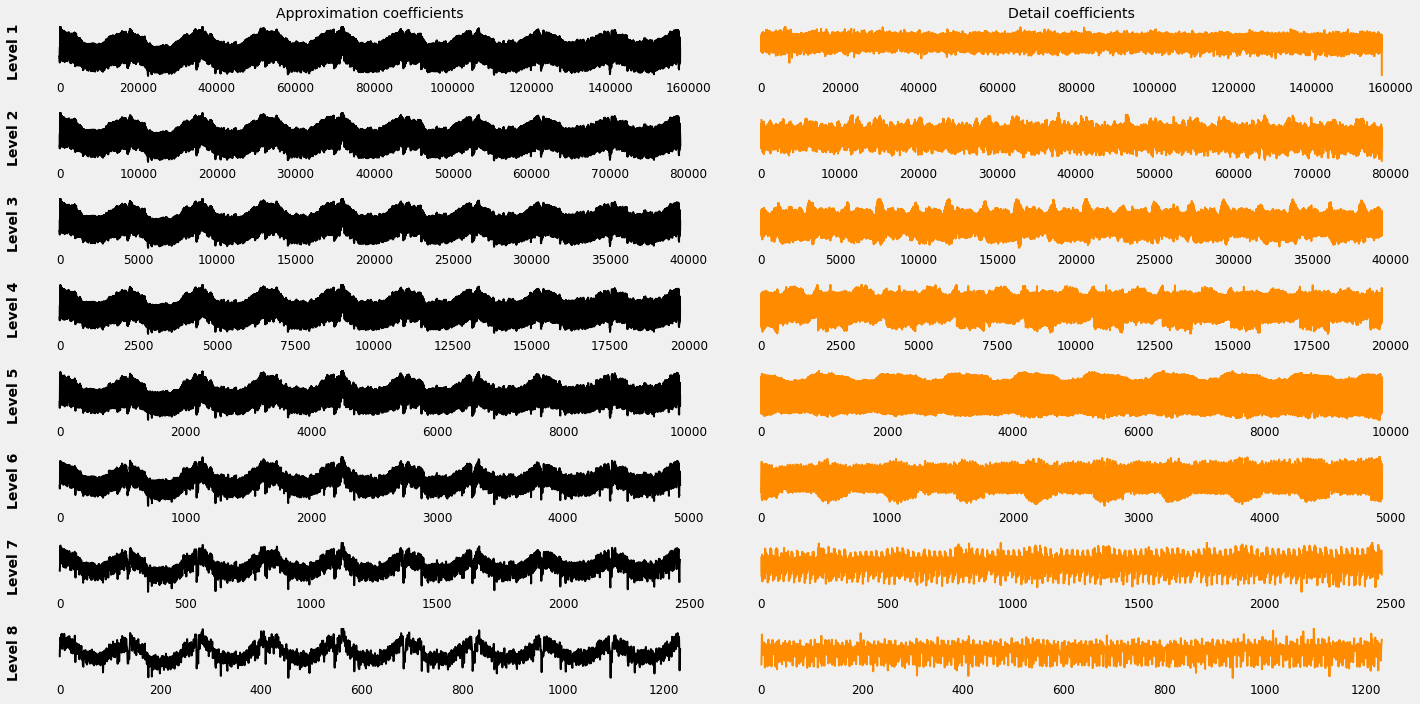

In [14]:
#Performing the Wavelet transform using a sym2
week=data
time=week.seconds.max()
sample_rate=1/900.
size= int(sample_rate*time)
t = np.linspace(0, time, num=size)
dataset = np.array(week.Load.tolist())
waveletname = 'sym2'
levels=8
fig, axarr = plt.subplots(nrows=levels, ncols=2, figsize=(20,10))
COEFF_D=[]
DATASET=[]
k=1
for ii in range(levels):
    (dataset, coeff_d) = pywt.dwt(dataset, waveletname,mode='per')
    axarr[ii, 0].plot(dataset, 'black')
    axarr[ii, 1].plot(coeff_d, 'darkorange')
    axarr[ii, 0].set_ylabel("Level {}".format(ii + 1), fontsize=14, rotation=90)
    axarr[ii, 0].set_yticklabels([])
    if ii == 0:
        axarr[ii, 0].set_title("Approximation coefficients", fontsize=14)
        axarr[ii, 1].set_title("Detail coefficients", fontsize=14)
    axarr[ii, 1].set_yticklabels([])
    #print(len(coeff_d))
    COEFF_D.append(np.repeat(coeff_d,2**k))
    DATASET.append(np.repeat(dataset,2**k))
    k=k+1
plt.tight_layout()
plt.show()

In [15]:
#Preparing the gaussian fit 
def gaus(x,a,x0,sigma):
        return a*np.exp(-(x-x0)**2/(2*sigma**2))

 

In [16]:
#Histogram of the first coefficient 
x=np.histogram(COEFF_D[0],500)[1][0:500]
y=np.histogram(COEFF_D[0],500)[0]

In [17]:
#To restrict the number of values and fit the gaussian correctly, this function has been used
def takeClosest(num,collection):
    collection=collection.tolist()
    collection=np.array(collection)
    if num>=0:
        collection=np.abs(collection[np.where(collection>0)])
        a= min(collection,key=lambda x:abs(x-abs(num)))
    else:
        collection=np.abs(collection[np.where(collection<0)])

        a= -min(collection,key=lambda x:abs(x-abs(num)))
    return a

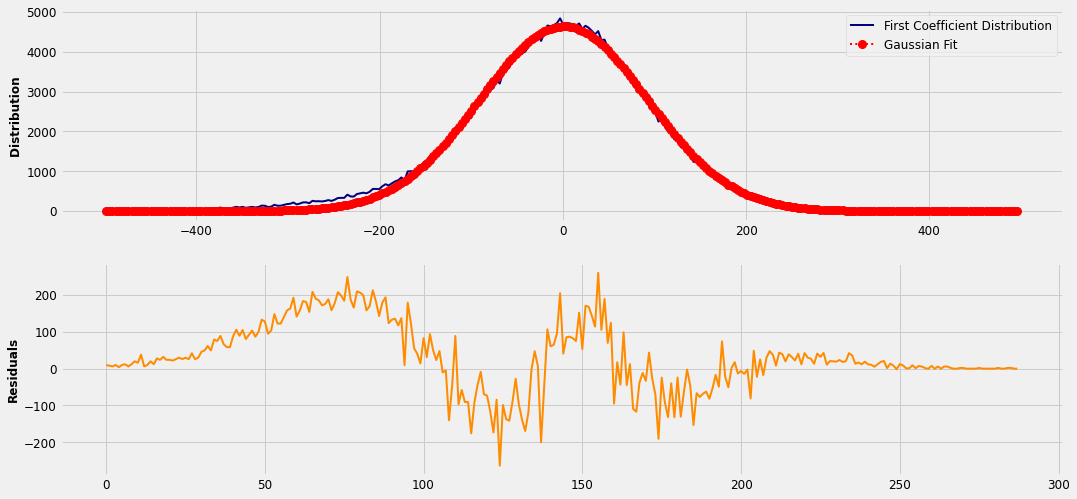

In [18]:
#Gaussian Fit
x_try=x
b=x.tolist().index(takeClosest(500,x))
a=x.tolist().index(takeClosest(-500,x))
x=x[a:b]
y=y[a:b]


val_medio=x[int(len(x)/2)]
n = len(x)                       #the number of data
mean = sum(x*y)/n                   #note this correction
sigma = sum(y*(x-val_medio)**2)/n        #note this correction
p0 = [max(y),val_medio,10]
popt,pcov = curve_fit(gaus,x,y,p0=p0)
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.set_ylabel('Distribution ')
ax1.plot(x,y,'navy',label='First Coefficient Distribution')
ax1.grid(True)
plt.ylabel('Residuals')
ax1.plot(x,gaus(x,*popt),'ro:',label='Gaussian Fit')
ax1.legend()
res = y - gaus(x,*popt)
ax2.plot(res,color='darkorange')
ax2.grid(True)
plt.show()



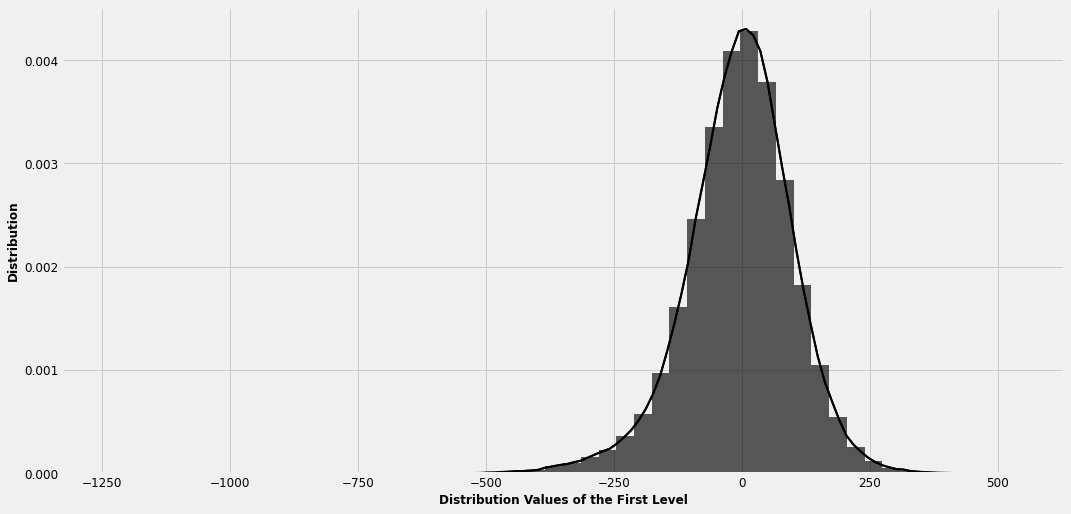

In [19]:
x=sns.distplot(COEFF_D[0],color='k').get_lines()[0].get_data()[0][a:b]
y=sns.distplot(COEFF_D[0],color='k').get_lines()[0].get_data()[1][a:b]
plt.ylabel('Distribution')
plt.xlabel('Distribution Values of the First Level')
plt.grid(True)

In [20]:
Sigma=popt[2]

In [36]:
#Defining the reconstruction with the threshold
def recons_from_th_zero(threshold):
    lim_1=-threshold*Sigma
    lim_2=-lim_1
    coeff_0=np.array(COEFF_D[0].copy())
    #mask = np.where((coeff_0<lim_2) & (coeff_0>lim_1))
    coeff_0[np.where((coeff_0<lim_2) & (coeff_0>lim_1))]=0
    level_0=coeff_0+DATASET[0]
    MAX=level_0.max()
    return level_0*(data.Load.max()/MAX)

In [24]:
#Data test
test=np.array(data.Load)

In [25]:
#Threshold, large range
TH=np.arange(0.0,13.25,0.5)
C_TH=[]
for t in TH:
    rec=recons_from_th_zero(t)
    C_TH.append(np.abs(np.corrcoef(rec-test,test)[0][1]))

In [29]:
#Threshold, narrow range
TH=np.arange(0.0,1.01,0.01)
C_TH=[]
for t in TH:
    rec=recons_from_th_zero(t)
    C_TH.append(np.abs(np.corrcoef(rec-test,test)[0][1]))

In [37]:
#Best threshold
print('The Correlation has the following percentage: '+str(100*C_TH[-1]) +'%')

The Correlation has the following percentage: 0.19961946310021011%


In [53]:
#Mean and extreme value
mean=popt[1]
lim_neg=mean-1*Sigma
lim_pos=mean+1*Sigma

In [78]:
lim_1=-1*Sigma
lim_2=-lim_1
coeff_0=np.array(COEFF_D[0].copy())
#mask = np.where((coeff_0<lim_2) & (coeff_0>lim_1))
#coeff_0[np.where((coeff_0<lim_2) & (coeff_0>lim_1))]=0

In [101]:
x_hist=np.histogram(coeff_0,199)[1]
y_hist=np.histogram(coeff_0,200)[0]
filt_coeff_0=coeff_0[np.where((coeff_0<lim_2) & (coeff_0>lim_1))]

In [104]:
x_left=x_hist[np.where((x_hist<lim_neg) & (x_hist>-500))]
x_right=x_hist[np.where(x_hist>lim_pos)]
y_left=y_hist[np.where((x_hist<lim_neg) & (x_hist>-500))]
y_right=y_hist[np.where(x_hist>lim_pos)]
x_mid=x_hist[np.where((x_hist>lim_neg) & (x_hist<lim_pos))]
y_mid=y_hist[np.where((x_hist>lim_neg) & (x_hist<lim_pos))]




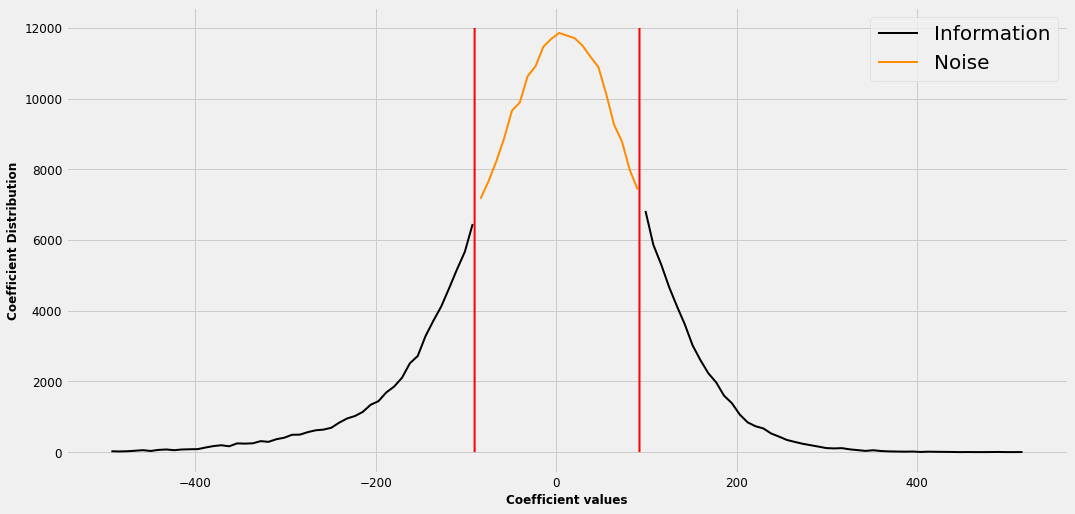

In [111]:
plt.plot(x_left,y_left,color='k')
plt.plot(x_right,y_right,color='k',label='Information')
plt.plot(x_mid,y_mid,color='darkorange',label='Noise')
plt.plot(np.zeros(12000)+lim_neg,np.arange(0,12000),color='red')
plt.plot(np.zeros(12000)+lim_pos,np.arange(0,12000),color='red')

plt.grid(True)
plt.xlabel('Coefficient values')
plt.ylabel('Coefficient Distribution')
plt.legend(fontsize=20)